In [243]:
%reset 

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2" 
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib import units
from tensorflow.keras.optimizers import Adam
import os
from glob import glob
import shutil
import time
from IPython.display import clear_output
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import shutil
import PIL
from tensorflow.keras import layers
import pickle
AUTOTUNE = tf.data.AUTOTUNE
import tensorflow_ranking as tfr

In [5]:
batch_size = 32
img_height = 150
img_width = 150
dtrain = tf.keras.utils.image_dataset_from_directory(
  '../vs/data/dataset/dog-cat/Test-Val-PetImages/train/',
  image_size=(img_height, img_width),
  color_mode="rgb",
  batch_size=batch_size,
  label_mode="categorical")

dtest = tf.keras.utils.image_dataset_from_directory(
  '../vs/data/dataset/dog-cat/Test-Val-PetImages/val/',
  image_size=(img_height, img_width),
  color_mode="rgb",
  batch_size=batch_size,
  label_mode="categorical")

Found 19925 files belonging to 2 classes.
Found 4985 files belonging to 2 classes.


In [3]:
class_names = ['Cat', 'Dog']
print(class_names)

['Cat', 'Dog']


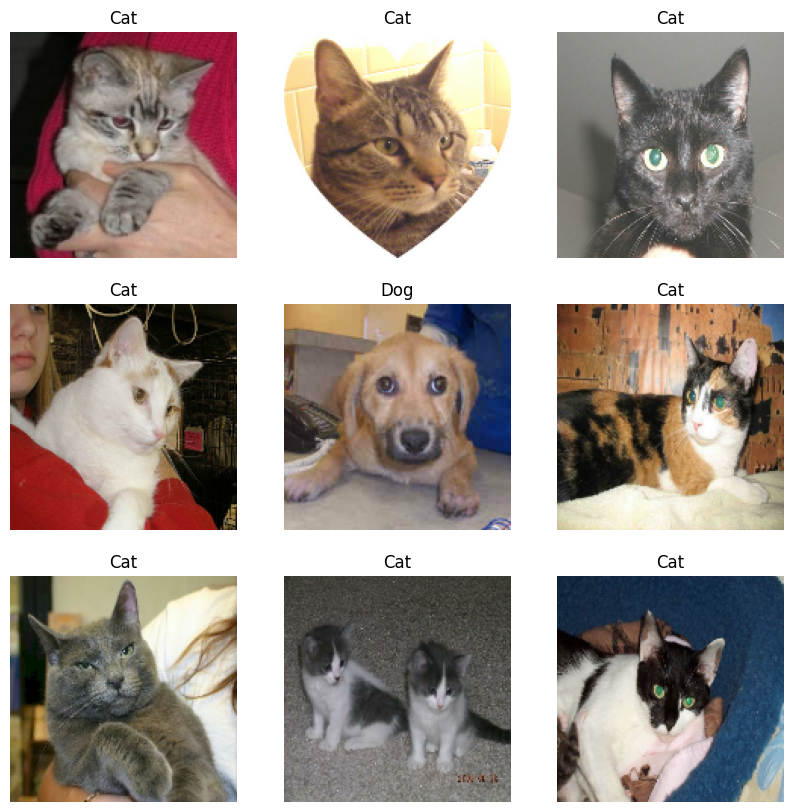

In [247]:
plt.figure(figsize=(10, 10))
for images, labels in dtrain.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [297]:
dtrain = dtrain.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dtest = dtest.cache().prefetch(buffer_size=AUTOTUNE)

In [298]:
classes=len(class_names)
opt=tf.keras.optimizers.Adam(0.001)
model=tf.keras.models.Sequential()
model.add(layers.Rescaling(1./255,input_shape=(img_height, img_width, 3)))
model.add(layers.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)))
model.add(layers.RandomRotation(0.1))
model.add(layers.Conv2D(16,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128,activation="sigmoid"))
model.add(layers.Dense(classes,activation="sigmoid"))

model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [299]:
history = model.fit(dtrain,validation_data=dtest,epochs=10)

Epoch 1/10
623/623 [==============================] - 157s 250ms/step - loss: 0.6850 - accuracy: 0.5616 - val_loss: 0.6412 - val_accuracy: 0.6514
Epoch 2/10
623/623 [==============================] - 157s 252ms/step - loss: 0.6258 - accuracy: 0.6716 - val_loss: 0.5875 - val_accuracy: 0.7137
Epoch 3/10
623/623 [==============================] - 187s 300ms/step - loss: 0.5839 - accuracy: 0.7136 - val_loss: 0.5826 - val_accuracy: 0.7284
Epoch 4/10
623/623 [==============================] - 200s 321ms/step - loss: 0.5578 - accuracy: 0.7385 - val_loss: 0.5223 - val_accuracy: 0.7775
Epoch 5/10
623/623 [==============================] - 184s 295ms/step - loss: 0.5347 - accuracy: 0.7661 - val_loss: 0.5047 - val_accuracy: 0.7922
Epoch 6/10
623/623 [==============================] - 179s 287ms/step - loss: 0.5174 - accuracy: 0.7770 - val_loss: 0.4983 - val_accuracy: 0.7914
Epoch 7/10
623/623 [==============================] - 181s 291ms/step - loss: 0.5065 - accuracy: 0.7880 - val_loss: 0.4745 -

In [282]:
model.save("../vs/data/model/modeldogcat.model")

In [6]:
model = tf.keras.models.load_model("../vs/data/model/modeldogcat.model")

1/1 [==============================] - 0s 29ms/step
This image used to be Dog 
but most likely belongs to Dog 
with a 59.10 percent confidence.
[[0.43773013 0.5910301 ]]


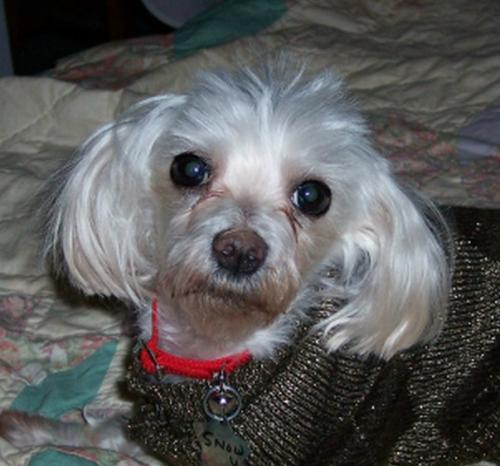

In [11]:
from random import random
img_paths = glob('../vs/data/dataset/dog-cat/Test-Val-PetImages/val/*/*.jpg')
ind=int(random()*len(img_paths)-1)
# ind=4
img = tf.keras.utils.load_img(
    img_paths[ind], target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])
score = max(predictions)
print(
    "This image used to be {} \nbut most likely belongs to {} \nwith a {:.2f} percent confidence.\n{}"
    .format(img_paths[ind].split("\\")[-2],class_names[np.argmax(score)], 100 * np.max(score),predictions)
)
PIL.Image.open(img_paths[ind])


1/1 [==============================] - 0s 30ms/step
[[0.6659439  0.28401026]]
This image used to be dandelion 
but most likely belongs to Cat 
with a 66.59 percent confidence.
[[0.6659439  0.28401026]]


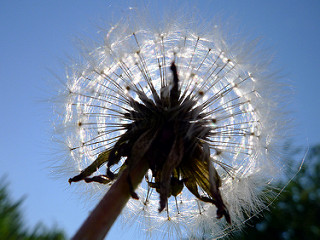

In [314]:
from random import random
img_paths = glob('../vs/data/dataset/flowers/*/*.jpg')
ind=int(random()*len(img_paths)-1)
img = tf.keras.utils.load_img(
    img_paths[ind], target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = max(predictions)
print(predictions)
print("This image used to be {} \nbut most likely belongs to {} \nwith a {:.2f} percent confidence.\n{}".format(img_paths[ind].split("\\")[-2],class_names[np.argmax(score)], 100 * np.max(score),predictions))

PIL.Image.open(img_paths[ind])

In [ ]:
tf.nn.softmax(predictions[0])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.22742775, 0.27502662, 0.49754554], dtype=float32)>

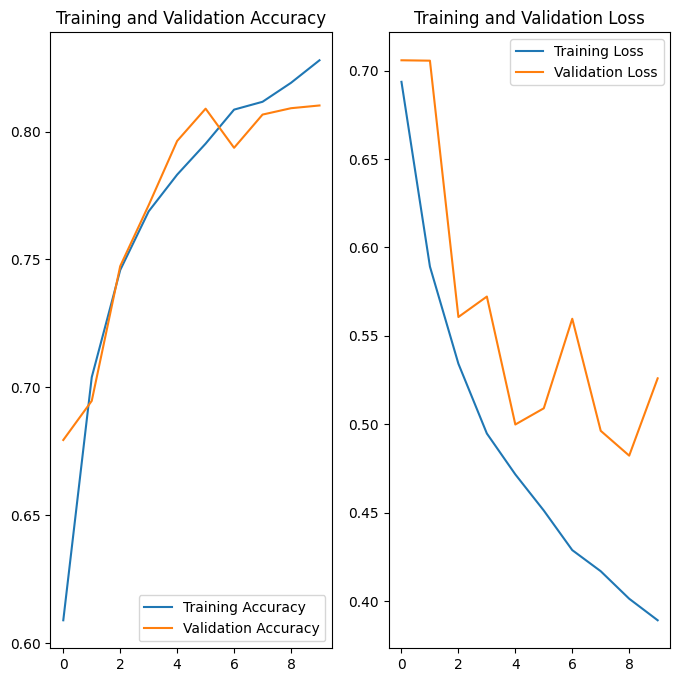

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
img_paths = glob('../vs/data/dataset/dog-cat/Test-Val-PetImages/*/*.jpg')
bad_paths = []

for image_path in img_paths:
    try:
      img_bytes = tf.io.read_file(image_path)
      decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
      print(f"Found bad path {image_path}...{e}")
      bad_paths.append(image_path)
print("BAD PATHS:")
for bad_path in bad_paths:
    print(f"{bad_path}")

BAD PATHS:


In [ ]:
#import splitfolders
#splitfolders.ratio('PetImages', output="./Test", seed=1337, ratio=(.8, 0.2))